# VGG16 Transfer Learning - xray

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as K
print(f"tf: {tf.__version__}")

tf: 2.4.1


In [3]:
import pydicom

# Part 1. Use a custom image data generator which takes in DICOM images.

### Load the CSV file you saved in Part 1 in a pandas DataFrame

In [4]:
# Import the larger file so I can later stratify on where the images came from if I want to
df = pd.read_csv('../data/xray_dataset_full.csv')
df.head(3)

,file,has_covid,dcm_file
0,../data/COVID-19_Radiography_Dataset/COVID/COV...,1,../data/dicom_xray/covid/covidchest_0.dcm
1,../data/COVID-19_Radiography_Dataset/COVID/COV...,1,../data/dicom_xray/covid/covidchest_1.dcm
2,../data/COVID-19_Radiography_Dataset/COVID/COV...,1,../data/dicom_xray/covid/covidchest_2.dcm


In [5]:
# sanity checks
print(f"total files: {df.shape[0]}")
print(f"total covid: {df['has_covid'].sum()}")
print(f"overall fraction covid: {df['has_covid'].sum()/df.shape[0]:.2}")

total files: 21165
total covid: 3616
overall fraction covid: 0.17


### Split n the DataFrame into train, test DataFrame using the function train_test_split(test_size=0.2) from the sklearn.model_selection library

In [6]:
# This is how I've used train_test_split in the past
if (0):

    X = df['dcm_file']
    y = df['has_covid']
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

    print(X_train[:2],y_train[:2])

    # sanity checks
    print(f"TRAIN:  {len(X_train)}  fraction covid: {sum(y_train)/len(y_train):.2}")
    print(f"VALID:   {len(X_valid)}  fraction covid: {sum(y_valid)/len(y_valid):.2}")
    print(f"TEST:    {len(X_test)}  fraction covid: {sum(y_test)/len(y_test):.2}")

In [7]:
# Learning a few new tricks..


df['has_covid'] = df['has_covid'].apply(str) # trying to fix the TypeError occuring later

# Only pass the columns I need to the split

train_df, test_df = train_test_split(df[['dcm_file','has_covid']], test_size=0.2, random_state=42)

In [8]:
print(train_df.shape, test_df.shape)

(16932, 2) (4233, 2)


In [9]:
train_df.head(3)

,dcm_file,has_covid
7861,../data/dicom_xray/no_covid/nocovidchest_4245.dcm,0
14378,../data/dicom_xray/no_covid/nocovidchest_10762...,0
14102,../data/dicom_xray/no_covid/nocovidchest_10486...,0


### Add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function.

This workflow is not my usual, but I'm going to try it out. Starting with a copy from the hint.

In [10]:
# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'categorical' # 'binary'
COLOR_MODE = 'rgb' # 'grayscale'
TARGET_SIZE = (224,224) # (300, 300)
EPOCHS = 10
SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}


### Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE, and EPOCHS.

In [11]:
# most training parameters were set above
use_epochs = 5  # 5 for sanity check, 5000 for actual run

checkpoint_model_full = 'model_best_vgg16.h5'

### Create a data generator class for reading in DICOM images or use the class provided. With this custom datagenerator class create a train and validation generator.

I've used several methods to ingest data, but not a custom class. I'm opting to use, dissect, and possibly transform the class provided.

In [12]:
#from tensorflow.keras import DataFrameIterator
#from tensorflow.keras.keras_preprocessing import DataFrameIterator
#from tensorflow.keras.preprocessing.image import DataFrameIterator
#from keras.preprocessing.image import DataFrameIterator

# None of these worked, but I do see the class listed in the docs at
# https://keras.io/api/preprocessing/image/ right under flow_from_dataframe

In [13]:
#tf.keras.preprocessing.image.ImageDataGenerator # yes, this works

In [14]:
#tf.keras.preprocessing.image.DataFrameIterator # no

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

In [16]:
# From DCMDataFrameIterator.py
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]

        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str
        # mod because of error
        #batch_y = np.array(self.y.iloc[indices_array]) # .astype(str) does not solve the problem
        
        
        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array


In [17]:
# # can't seem to get rid of error
# # TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.
# # try converting the column
# # TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.
# train_df['has_covid'] = train_df['has_covid'].apply(str)
# test_df['has_covid'] = test_df['has_covid'].astype(str)

# # but this triggers the message about setting value on a slice from a DataFrame

In [18]:
# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(
        dataframe=train_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=train_augmenter,
        **train_consts)

valid_generator = DCMDataFrameIterator(
        dataframe=train_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=valid_augmenter,
        **valid_consts)

Found 13546 validated image filenames belonging to 2 classes.
Found 3386 validated image filenames belonging to 2 classes.


In [19]:
# TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.

# Part 2. Build a VGG 16 model from scratch and train using X-ray images

### Build the VGG16 model from scratch using correct layers and activations.

In [20]:
num_categories = 2

In [21]:
print(TARGET_SIZE)

(224, 224)


### Use the classic method and just build it

In [22]:
#from keras.applications.vgg16 import VGG16
# From "Deep Learning for Vision Systems"
 
base_model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, 
                   input_shape = (224,224, 3))
base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:

# from keras.layers import Dense, Flatten
# from keras.models import Model
 
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = K.layers.Flatten()(last_output)
 
x = K.layers.Dense(2, activation='softmax', name='softmax')(x)
#x = K.layers.Dense(1, activation='sigmoid', name='sigmoid')(x)


In [24]:
model = K.models.Model(inputs=base_model.input, outputs=x)
 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Compile the model and check model summary.

In [25]:
# Compile the model with the model parameters
# opt = K.optimizers.Adam(lr=0.0001) # Run 1
opt = K.optimizers.Adam(lr=0.01)     # Run 2

model.compile(optimizer=opt, 
              #loss=K.losses.categorical_crossentropy, 
              #loss = K.losses.binary_crossentropy,
              loss = K.losses.sparse_categorical_crossentropy,
              #loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']                        # other metrics to produce
             )

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Using the model.fit_generator function of Keras, train the model using the train_generator and validation_generator you built.
Plot the training loss. accuracy, and validation loss. and accuracy values vs. epochs.
Load a set of 9 random images from the test_generator, run model.predict on them. and visualize the prediction scores along with the test images

In [27]:
# Save the model if the validation accuracy has improved over the previous epoch
checkpoint = K.callbacks.ModelCheckpoint(checkpoint_model_full, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', 
                             save_freq = 1 #  specify the frequency in number of batches seen. replaces period=1
                                        )

# Stop training early if the validation accuracy has not improved
early = K.callbacks.EarlyStopping(monitor='val_accuracy',  # parameter to monitor
                      min_delta=0,             # minimum improvement
                      patience=20,             # how many epochs to wait
                      verbose=1, mode='auto')

In [28]:
# check with just a few epochs to start
use_epochs = 5

In [29]:
# Started, so it is probably good
if(0):
    history = model.fit_generator(         # 
        generator = train_generator,           # training images
        validation_data= valid_generator,     # validation images
        epochs=use_epochs#,                  # training cycles
        #callbacks=[checkpoint,early]
        )

In [30]:
# runs with fit_generator(); does not run with just .fit()
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=use_epochs,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
    )


/opt/anaconda3/envs/liveproject-dicom/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
424/424 [==============================] - 1266s 3s/step - loss: 39.7401 - accuracy: 0.8510 - val_loss: 15.5709 - val_accuracy: 0.9409
Epoch 2/5
424/424 [==============================] - 1101s 3s/step - loss: 23.5043 - accuracy: 0.9137 - val_loss: 12.4372 - val_accuracy: 0.9504
Epoch 3/5
424/424 [==============================] - 1106s 3s/step - loss: 30.4623 - accuracy: 0.9170 - val_loss: 26.9377 - val_accuracy: 0.9365
Epoch 4/5
424/424 [==============================] - 1101s 3s/step - loss: 20.5965 - accuracy: 0.9371 - val_loss: 22.4433 - val_accuracy: 0.9468
Epoch 5/5
424/424 [==============================] - 1102s 3s/step - loss: 25.2283 - accuracy: 0.9368 - val_loss: 18.8587 - val_accuracy: 0.9516


In [31]:
# Using the testing generator to evaluate the model after training
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=test_augmenter,
        **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

Found 4233 validated image filenames belonging to 2 classes.
4233/4233 [==============================] - 341s 81ms/step - loss: 27.8444 - accuracy: 0.9457


### Plot the training loss. accuracy, and validation loss. and accuracy values vs. epochs.

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

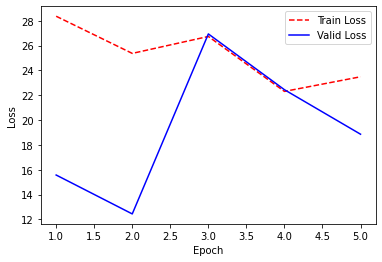

In [34]:
# Loss
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

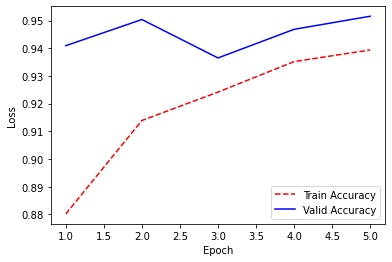

In [35]:
# Accuracy
plt.plot(epoch_count, train_acc, 'r--')
plt.plot(epoch_count, valid_acc, 'b-')
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Based on the plots, the model is still learning, so I could train for more epochs. This took a long time on my mac, though, so I'm going to move on.

# Save the model in .h5 format.

https://www.tensorflow.org/guide/keras/save_and_serialize#:~:text=There%20are%20two%20formats%20you%20can%20use%20to,that%20ends%20in%20.h5%20or%20.keras%20to%20save%28%29.

"There are two formats you can use to save an entire model to disk: the TensorFlow SavedModel format, and the older Keras H5 format. The recommended format is SavedModel. It is the default when you use model.save()."

In [36]:
model.save('./vgg_xray_xfer_lr01.h5')

# Load trained model and do predictions on 10 X-ray images.

In [37]:
model = K.models.load_model('./vgg_xray_xfer_lr01.h5')

In [38]:
test_result = model.predict(test_generator, steps=1)

In [39]:
test_result

array([[1., 0.]], dtype=float32)

In [40]:
# Choose 10 random images
idx_list = np.random.choice(range(len(test_generator)),10,replace=False)
idx_list

array([  98, 2234, 1799, 2622, 2946, 2668, 1173, 2411, 1574, 1484])

In [41]:
test_generator[101][1] # find the y_true

array([0], dtype=uint8)

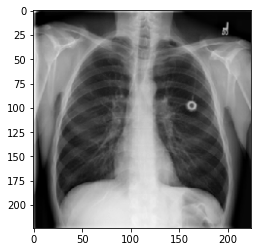

In [42]:
# find the image
plt.imshow(test_generator[101][0][0,:,:,0],cmap='gray')

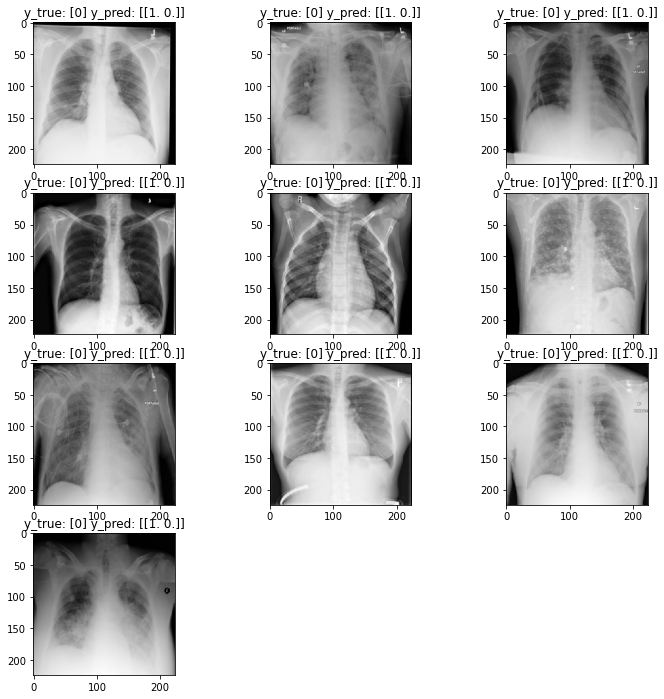

In [43]:
fig = plt.figure(figsize=(12,12))
axes = []
res_list = []
for i,idx in enumerate(idx_list):
    ax1 = fig.add_subplot(4,3,i+1)
    plt.imshow(test_generator[idx][0][0,:,:,0],cmap='gray')
    res = model.predict(test_generator[idx][0],1)
    res_list.append(res)
    plt.title(f"y_true: {test_generator[idx][1]} y_pred: {res}")

In [44]:
# Tally the results:
# Run 1 - lr=0.0001, 5 epochs    './vgg_xray_xfer.h5'
# train_acc: 0.856267511844635 0.908017098903656 0.9202716946601868 0.9305329918861389 0.933264434337616
# valid_acc: 0.9105138778686523 0.9181925654411316 0.9415239095687866 0.9453632831573486 0.9444772601127625
# train_loss: 1.1479318141937256 0.6201808452606201 0.5226723551750183 0.4505225121974945 0.42096543312072754
# valid_loss: 0.808472752571106 0.6814015507698059 0.4506649971008301 0.42848822474479675 0.40728363394737244
# res_list: [[1.00000e+00 1.70657e-10]] [[1.000000e+00 5.481572e-10]] [[1.0000000e+00 1.8533485e-13]] \
#      [[1.000000e+00 4.680838e-13]] [[1.000000e+00 3.459081e-19]] [[1.0000000e+00 2.8912748e-14]] \
#      [[1.000000e+00 8.168133e-12]] [[1.000000e+00 9.026319e-17]] [[1.0000000e+00 4.6347637e-10]] \
#      [[9.9993885e-01 6.1146602e-05]]
# Run 2 - lr=0.001, 5 epochs     './vgg_xray_xfer_lr01.h5'
# train_acc: 0.8801860213279724 0.913922905921936 0.924184262752533 0.9351838231086731 0.9393916726112366
# valid_acc: 0.9409332275390625 0.9503839612007141 0.9365032315254211 0.9468399286270142 0.9515652656555176
# train_loss: 28.36217498779297 25.369388580322266 26.73335838317871 22.3065185546875 23.48590660095215
# valid_loss: 15.570892333984375 12.43718147277832 26.937726974487305 22.443328857421875 18.858652114868164
# res_list: [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]]

In [45]:
print(*train_acc)

0.8801860213279724 0.913922905921936 0.924184262752533 0.9351838231086731 0.9393916726112366


In [46]:
print(*train_loss)

28.36217498779297 25.369388580322266 26.73335838317871 22.3065185546875 23.48590660095215


In [47]:
print(*valid_acc)

0.9409332275390625 0.9503839612007141 0.9365032315254211 0.9468399286270142 0.9515652656555176


In [48]:
print(*valid_loss)

15.570892333984375 12.43718147277832 26.937726974487305 22.443328857421875 18.858652114868164


In [50]:
print(*res_list)

[[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]] [[1. 0.]]


# Conclusion

- 5 epochs is not enough
- *Starting with a faster learning rate of .01 as compared to .0001, only 5 epochs doesn't look great.* However, recent experience has taught me that starting with a larger learning rate can avoid getting stuck in a local minima, so I'd like to run this longer before deciding which is better.
- Since I did not set this up with gridsearch, and I didn't see the course pointing to taking that route, I'm going to stop here and move on to the next week because it includes tools I have not yet used.

I'm also opting not to repeat this with ResNet, at least not for now, as I want to move on. I anticpate that when I do come back to it,
- ResNet will run faster
- Likely to have better outcomes
- outcome for CT will have the greatest improvement by using ResNet + transfer learning since it is a small dataset